In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from deluca.agents import BPC, LQR, BCOMC
from deluca.envs import LDS
import jax.numpy as jnp
import jax
import numpy as np

from jax.config import config
config.update("jax_debug_nans", True)
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
PRINT_RATE = 1000
def get_err(T, lds, controller, noise, random_key=jax.random.PRNGKey(42)):
    lds.reset()
    avg_err = 0
    err = 0
    err_list = []
    prev_noise = jnp.zeros(shape=lds.state.shape)
    key = random_key
    last_avg_err = 0
    for i in range(T):

        key, subkey = jax.random.split(key)
        try:
            action = controller(lds.obs, err)
        except:
            action = controller(lds.obs)
        lds.step(action)
        if noise == "Gaussian":
            lds.state += 0.03 * jax.random.normal(subkey, shape=lds.state.shape)
        elif noise == "Sinusoidal":
            lds.state += 0.03 * jnp.sin(i/(20 * np.pi))
        elif noise == "GaussianWalk":
            prev_noise = prev_noise + jax.random.normal(subkey, shape=lds.state.shape)
            lds.state += 0.03 * prev_noise / np.sqrt(T)
        elif noise == "None":
            pass
        else:
            raise ValueError("Noise type unrecognized!")
        err = (jnp.linalg.norm(lds.state)**2+jnp.linalg.norm(action)**2)
        last_avg_err += err
        if (i+1) % PRINT_RATE == 0:
            print(str(i+1) + " avg err:", last_avg_err/PRINT_RATE)
            last_avg_err = 0
        avg_err += err/T
        err_list += [err]
    return avg_err, np.array(err_list)

In [4]:
T = 100000

system = "DI" # one of "DI", "LargeSparse"
noise = "Gaussian" # one of "Gaussian", "GaussianWalk", "SinusoidalMult", "None"

if system == "DI":
    A = jnp.array([[.9, .9], [-0.01, .9]])
    B = jnp.array([[0], [1]])
elif system == "LargeSparse":
    A = jnp.array([[.3, 0, 0, .4, .1], [0, .5, .5, .5, 0], [.05, .05, .05, .05, 0], [.3, 0, 0, 0, 0], [4, 0, 0, 0, .1]])
    B = jnp.array([[2, 0, 0], [0, .3, .1], [0, .1, .3], [0, 0, 0], [0, 0, 0]])
else:
    raise ValueError("System type unrecognized!")
print("System norm:", )
#A,B = jnp.array([[.8,.5], [0,.8]]), jnp.array([[0],[0.8]])


System norm:


In [5]:
bpc = BPC(A, B, lr_scale=1e-3, delta=1/T)
bpc_avg_err, bpc_errs = get_err(T, LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), bpc, noise)
print("BPC incurs ", bpc_avg_err, " loss")

1000 avg err: 0.2085600252777553
2000 avg err: 0.16115680765130722
3000 avg err: 0.12243238034011568
4000 avg err: 0.13418968056642727
5000 avg err: 0.1344304634521139
6000 avg err: 0.18024787671771889
7000 avg err: 0.13371156638039314
8000 avg err: 0.13782749209087294
9000 avg err: 0.1227034590182228
10000 avg err: 0.17324913541355785
11000 avg err: 0.11883848247904505
12000 avg err: 0.10887566724642944
13000 avg err: 0.08588867382639928
14000 avg err: 0.12745654533904197
15000 avg err: 0.11116408871905174
16000 avg err: 0.1263217373794717
17000 avg err: 0.12865481558711062
18000 avg err: 0.17002138492188926
19000 avg err: 0.14637076062491136
20000 avg err: 0.1168288059263728
21000 avg err: 0.11507440217280722
22000 avg err: 0.13060846655268576
23000 avg err: 0.17651004051347852
24000 avg err: 0.1538681115045772
25000 avg err: 0.12489732380680292
26000 avg err: 0.13743107293151013
27000 avg err: 0.17171611842627688
28000 avg err: 0.15389160978674804
29000 avg err: 0.23005514915128583


In [6]:
lqr = LQR(A, B)
lqr_avg_err, lqr_errs = get_err(T, LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), lqr, noise)
print("LQR incurs ", lqr_avg_err, " loss")

1000 avg err: 0.012789924889811219
2000 avg err: 0.011161945000522751
3000 avg err: 0.009890018890762756
4000 avg err: 0.010436330974304986
5000 avg err: 0.010463193371527986
6000 avg err: 0.009623811379981532
7000 avg err: 0.010533036251848144
8000 avg err: 0.010696350280733699
9000 avg err: 0.009518786184210029
10000 avg err: 0.011164774049662488
11000 avg err: 0.00982795987352996
12000 avg err: 0.010783514874321444
13000 avg err: 0.009982156453853287
14000 avg err: 0.010620253429813683
15000 avg err: 0.009823768105086754
16000 avg err: 0.011097304401004371
17000 avg err: 0.011307623245440686
18000 avg err: 0.010711153331965413
19000 avg err: 0.011691718151132001
20000 avg err: 0.009934164944502053
21000 avg err: 0.01014197952942728
22000 avg err: 0.01081396887875341
23000 avg err: 0.012147032413538431
24000 avg err: 0.010452227558066374
25000 avg err: 0.009454803891398907
26000 avg err: 0.010831008327583234
27000 avg err: 0.010247300744488923
28000 avg err: 0.010619606059554055
2900

In [8]:
bcomc = BCOMC(
    A = A,
    B = B,
    C = jnp.identity(A.shape[0]),
    T = T,
    H = 5,   # To change, but good for debug
    cost_bound = 1e5,
    R = 3,
    beta = 5.0,
    sigma = 0.2,
    eta_mul = 2e4,
    grad_mul = 1e-4, # Typically wants to decrease as eta_mul increases to offset its effect
)
bcomc_avg_err, bcomc_errs = get_err(T, LDS(state_size=B.shape[0], action_size=B.shape[1], A=A, B=B), bcomc, noise)
print("BCOMC incurs ", bcomc_avg_err, " loss")

eta: 0.008285052244289048
1000 avg err: 27.250166004204125
2000 avg err: 14.24705162957195
3000 avg err: 6.217200167868988
4000 avg err: 2.326714712398477
5000 avg err: 1.5114755385749128
6000 avg err: 1.8715820432233836
7000 avg err: 1.411683717022436
8000 avg err: 1.6439860993633164
9000 avg err: 1.1122972591827807
10000 avg err: 0.9236294716630447
11000 avg err: 0.7694936805114391
12000 avg err: 0.9416043567301825
13000 avg err: 0.558979911607211
14000 avg err: 0.828895147073111
15000 avg err: 0.6896587855484516
16000 avg err: 0.5816346932938756
17000 avg err: 0.7343068640747368
18000 avg err: 0.9325103551351263
19000 avg err: 0.8307396483303502
20000 avg err: 0.4125777541255249
21000 avg err: 0.6804644250079204
22000 avg err: 0.5411946343441233
23000 avg err: 0.7231678483315702
24000 avg err: 0.4852485829275578
25000 avg err: 0.42749834921535995
26000 avg err: 0.3850906333318654
27000 avg err: 0.3979864056739509
28000 avg err: 0.45967397751004474
29000 avg err: 0.6006869621367928
3

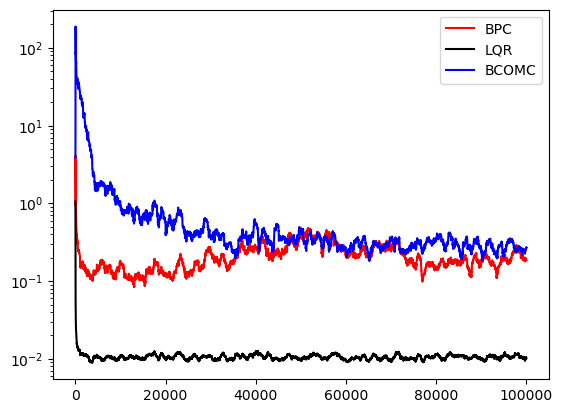

In [9]:
def mavg(data, period=1000):
    recent_sum = np.cumsum(data)
    recent_sum[period:] -= recent_sum[:-period]
    norm = np.cumsum(np.ones(data.shape))
    norm[period:] -= norm[:-period]
    return recent_sum / norm

import matplotlib.pyplot as plt
colors = {"BPC": "red", "LQR": "black", "BCOMC": "blue"}
plt.plot(mavg(bpc_errs), label="BPC", color=colors["BPC"])
plt.plot(mavg(lqr_errs), label="LQR", color=colors["LQR"])
plt.plot(mavg(bcomc_errs), label="BCOMC", color=colors["BCOMC"])
plt.legend()
plt.yscale('log')
plt.show()